# Introduction to Variational Auto-Encoders (VAEs)

Variational Auto-Encoders (VAEs) are a type of generative model that are widely used in machine learning for tasks such as image generation, anomaly detection, and data compression. In this notebook, we will introduce the basic concepts and theory behind VAEs, and provide simple code examples to help you get started with implementing them.

## Basic Concepts

VAEs are a type of auto-encoder, which is a neural network used to learn efficient representations of data, typically for the purpose of dimensionality reduction. However, unlike traditional auto-encoders, VAEs are probabilistic models that learn to generate new data points similar to the training data.

The key idea behind VAEs is to learn a latent space representation of the data, which is a lower-dimensional space that captures the essential features of the data. This latent space is then used to generate new data points by sampling from a probability distribution.

## Theory

The VAE consists of two main components: the encoder and the decoder. The encoder maps the input data to a latent space, while the decoder maps the latent space back to the original data space.

The encoder is typically a neural network that takes the input data and outputs the parameters of a probability distribution in the latent space. The decoder is another neural network that takes samples from this distribution and generates new data points.

The training of a VAE involves maximizing the likelihood of the data under the model, which is done by minimizing a loss function that consists of two terms: the reconstruction loss and the KL divergence. The reconstruction loss measures how well the decoder can reconstruct the input data from the latent space, while the KL divergence measures how close the learned distribution is to a prior distribution.

## Code Example

Let's start with a simple implementation of a VAE using PyTorch.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Define the Encoder

The encoder network takes the input data and outputs the parameters of the latent distribution (mean and log variance).

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_log_var = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h = self.relu(self.fc1(x))
        mean = self.fc2_mean(h)
        log_var = self.fc2_log_var(h)
        return mean, log_var

### Define the Decoder

The decoder network takes samples from the latent distribution and generates new data points.

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        h = self.relu(self.fc1(z))
        x_reconstructed = self.sigmoid(self.fc2(h))
        return x_reconstructed

### Define the VAE

The VAE model combines the encoder and decoder, and includes a sampling layer to sample from the latent distribution.

In [4]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        z = mean + std * epsilon
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mean, log_var

### Define the Loss Function

The loss function consists of the reconstruction loss and the KL divergence.

In [5]:
def vae_loss(x, x_reconstructed, mean, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

### Train the VAE

Let's train the VAE on a simple dataset, such as the MNIST dataset.

In [6]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define the VAE model
input_dim = 28 * 28
hidden_dim = 256
latent_dim = 2
encoder = Encoder(input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, input_dim)
vae = VAE(encoder, decoder)

# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x_reconstructed, mean, log_var = vae(x)
        loss = vae_loss(x, x_reconstructed, mean, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 7150299.78it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 260992.37it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2029789.12it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2265492.78it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Epoch 1, Loss: 182.6514552001953
Epoch 2, Loss: 165.24368096516926
Epoch 3, Loss: 161.51080247395834
Epoch 4, Loss: 159.12194900716145
Epoch 5, Loss: 157.41532638346354
Epoch 6, Loss: 156.18680362141927
Epoch 7, Loss: 155.20852910970052
Epoch 8, Loss: 154.32584979654948
Epoch 9, Loss: 153.60243400065104
Epoch 10, Loss: 152.96523545735678


### Visualize the Results

Let's visualize the latent space learned by the VAE and generate some new data points.

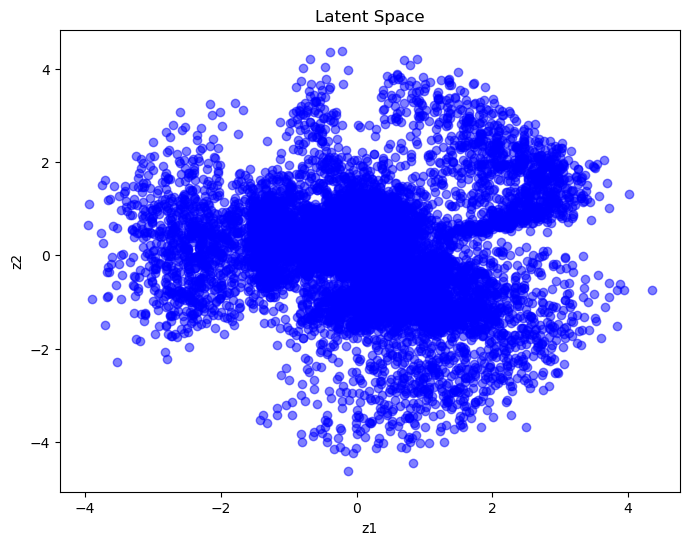

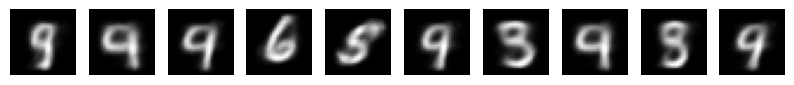

In [7]:
# Encode the test data to the latent space
vae.eval()
with torch.no_grad():
    z_mean, z_log_var = [], []
    for x, _ in test_loader:
        mean, log_var = vae.encoder(x)
        z_mean.append(mean)
        z_log_var.append(log_var)
    z_mean = torch.cat(z_mean)
    z_log_var = torch.cat(z_log_var)
    z = z_mean + torch.exp(0.5 * z_log_var) * torch.randn_like(z_mean)

# Plot the latent space
plt.figure(figsize=(8, 6))
plt.scatter(z[:, 0].numpy(), z[:, 1].numpy(), c='blue', alpha=0.5)
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Latent Space')
plt.show()

# Generate new data points
z_new = torch.randn(10, latent_dim)
with torch.no_grad():
    generated = vae.decoder(z_new)

# Plot the generated data points
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated[i].view(28, 28).numpy(), cmap='gray')
    plt.axis('off')
plt.show()